In [1]:
"""
Single-step ahead forecasting
Forecasting 1 step ahead using a LSTM network
"""

#Imports
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

In [2]:
#Load Data
data = pd.read_csv('data/AEP_hourly.csv', index_col=0, parse_dates=True)

#Sort the dataframe
data.sort_values('Datetime', inplace=True)

#scale the timeseries using standard scaler
ts = np.asarray(data['AEP_MW']).reshape(-1,1)
scaler = preprocessing.StandardScaler().fit(ts)
ts_scaled = list(scaler.transform(ts))

In [3]:
#Methods
def make_X_Y(ts:list, lag:int):
    """
    Create X and Y matrices needed for NN training
    """
    X,Y = [], []

    for i in range(len(ts) - lag):
        Y.append(ts[i + lag])
        X.append(ts[i:i+lag])

    X,Y = np.array(X), np.array(Y)

    #reshape array into standard form for timeseries
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    return X,Y

def make_train_test_data(ts:list, lag:int, train_test_split:float):
    """
    Create training and testing data for NN
    """
    #create X and Y matrices
    X,Y = make_X_Y(ts, lag)

    #split into test and train
    X_train = []
    X_test = []
    Y_train = []
    Y_test = []

    if train_test_split > 0:
        idx = round(len(X) * train_test_split)
        X_train = X[:(len(X) - idx)]
        X_test = X[-idx:]

        Y_train = Y[:(len(Y) - idx)]
        Y_test = Y[-idx:]

    return X_train, X_test, Y_train, Y_test

1-Step Ahead Prediction

In [4]:
#Deep Learning

#number of neurons in LSTM layer
n_layer = 50

#number of lags
n_lag = 3

#Model
model = keras.Sequential(
    [
    layers.LSTM(n_layer, activation='relu', input_shape=(n_lag,1)),
    layers.Dense(1)
    ]
)
#compile model
model.compile(optimizer='adam', loss='mse')

epochs = 10
batch_size = 256
train_test_split = 0.15

#create train and testing data
X_train, X_test, Y_train, Y_test = make_train_test_data(ts_scaled, n_lag, train_test_split)

#create a dict for keras training args
keras_dict = {
    'x':X_train,
    'y':Y_train,
    'batch_size':batch_size,
    'epochs':epochs,
    'shuffle':False,
    'validation_data':(X_test,Y_test)
}

In [5]:
#fit the model
model.fit(**keras_dict)

Epoch 1/10
403/403 [==============================] - 1s 2ms/step - loss: 0.1639 - val_loss: 0.0249
Epoch 2/10
403/403 [==============================] - 1s 2ms/step - loss: 0.0258 - val_loss: 0.0142
Epoch 3/10
403/403 [==============================] - 1s 2ms/step - loss: 0.0208 - val_loss: 0.0130
Epoch 4/10
403/403 [==============================] - 1s 2ms/step - loss: 0.0195 - val_loss: 0.0125
Epoch 5/10
403/403 [==============================] - 1s 2ms/step - loss: 0.0188 - val_loss: 0.0123
Epoch 6/10
403/403 [==============================] - 1s 2ms/step - loss: 0.0183 - val_loss: 0.0123
Epoch 7/10
403/403 [==============================] - 1s 2ms/step - loss: 0.0179 - val_loss: 0.0124
Epoch 8/10
403/403 [==============================] - 1s 2ms/step - loss: 0.0175 - val_loss: 0.0124
Epoch 9/10
403/403 [==============================] - 1s 2ms/step - loss: 0.0172 - val_loss: 0.0123
Epoch 10/10
403/403 [==============================] - 1s 2ms/step - loss: 0.0169 - val_loss: 0.0124

In [6]:
#predict
yhat = []
yhat = [y[0] for y in model.predict(X_test)]

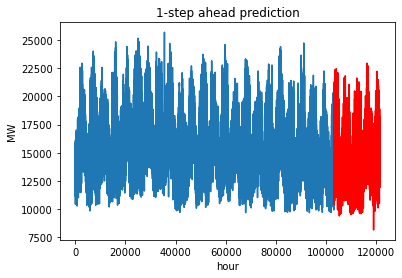

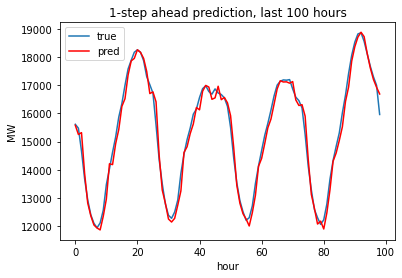

In [12]:
#Inverse transform scaled data
Y_train_inv = scaler.inverse_transform(np.asarray(Y_train))
Y_test_inv = scaler.inverse_transform(Y_test)
yhat_inv = list( (scaler.inverse_transform(np.asarray(yhat).reshape(-1,1))).squeeze() )

#Compare training data and 1 step ahead prediction
idx_train = len(Y_train)
idx_test = len(Y_test)
train_range = range(0, idx_train)
test_range = range(idx_train, idx_train + idx_test)
plt.plot(range(0,len(Y_train)),Y_train_inv)
plt.plot(test_range,yhat_inv,'r')
plt.title('1-step ahead prediction')
plt.xlabel('hour')
plt.ylabel('MW')
plt.show()

n_last = 100
plt.plot(Y_test_inv[-n_last:-1],label='true')
plt.plot(yhat_inv[-n_last:-1],'r',label='pred')
plt.title('1-step ahead prediction, last ' + str(n_last) + ' hours')
plt.xlabel('hour')
plt.ylabel('MW')
plt.legend()
plt.show()


In [9]:
Y_test_inv = scaler.inverse_transform(np.asarray(Y_test))
yhat_inv = list( (scaler.inverse_transform(np.asarray(yhat).reshape(-1,1))).squeeze() )

In [11]:
Y_test_inv[0]
yhat_inv[0]

12578.982